## Deploy Dask cluster on HTCondor

In [1]:
from dask_remote_jobqueue import RemoteHTCondor
cluster = RemoteHTCondor()

## Initialize the Dask client

In [2]:
from dask.distributed import Client
client = Client(address="tcp://127.0.0.1:"+str(cluster.sched_port))

## Declare your custom functions inside an initialization function

In [3]:
import ROOT

def my_initialization_function():
  ROOT.gInterpreter.Declare("""
  #include "ROOT/RVec.hxx"
  using namespace ROOT::VecOps;
  
  size_t SelectGoodMuons(const RVec<float> &pt){
    size_t n = 0;
    for (size_t i = 0; i < pt.size(); i++) {
        if (pt[i] > 50) n++;
    }
    return n;
  }
  """)

#### you can also declare functions inside a myfunctions.h file like this: #####
# text_file = open("myfunctions.h", "r")
# data = text_file.read()
# def my_initialization_function():
#    ROOT.gInterpreter.Declare('{}'.format(data))

ROOT.RDF.Experimental.Distributed.initialize(my_initialization_function)

Welcome to JupyROOT 6.25/01


## Create DataFrame and book operations

In [10]:
import ROOT 
 
# Create dataframe from NanoAOD files
df = ROOT.RDF.Experimental.Distributed.Dask.RDataFrame("Events", "https://ttedesch.web.cern.ch/ttedesch/cms_opendata_2012_nanoaod_skimmed/Run2012C_DoubleMuParked.root", npartitions=2, daskclient=client)
df_defined = df.Define("nMuons_over50", "SelectGoodMuons(Muon_pt)")
df_filtered = df_defined.Filter("nMuons_over50 > 0", "Filter events with at least 1 muon with pt>50 GeV")
h = df_filtered.Histo1D(("nMuons_over50","nMuons_over50",5,0,5),"nMuons_over50")

## Draw histo (the event loop is triggered here)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


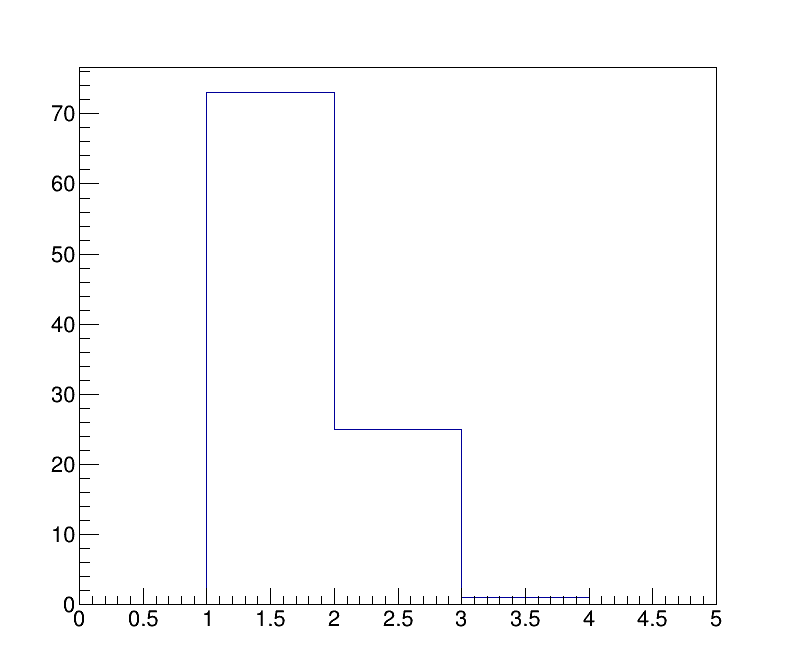

In [9]:
ROOT.gStyle.SetOptStat(0); ROOT.gStyle.SetTextFont(42)
c = ROOT.TCanvas("c", "", 800, 700)
h.SetTitle("")
h.GetXaxis().SetTitleSize(0.04)
h.GetYaxis().SetTitleSize(0.04)
h.Draw()
c.Draw()